<a href="https://colab.research.google.com/github/Karishma-Kuria/Assignment1-DL-CMPE-258/blob/main/Whitebox_DL_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This colab contains code to design and train nueral network using tensor flow used to recongnize handwritten digits. The colab used MNIST datset.

In this colab the below steps will be performed while designing a neural network. While performing each step the result will be visualized and ammendements will be made to increase the accuracy in each step.


1.   Using keras to build 1 layer neural network
2.   Adding more layers.
3. Setting up learning rate schedule.
4. Build convolutional neural network.
5. Using regularizing techniques: dropout and batch normalization
6. Using Overfitting



### Parameters

In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

### Importing Libraries

In [ ]:
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.7.0


### Visualization

In [ ]:
#@title 
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, validation_labels in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      break
    for training_digits, training_labels in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      break
    
  else:
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = batch_train_ds.make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  display.display(fig)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

parse files and prepare training and validation datasets

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image
  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(AUTO)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

# instantiate the datasets
training_dataset = get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)

# For TPU, we will need a function that returns the dataset
training_input_fn = lambda: get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_input_fn = lambda: get_validation_dataset(validation_images_file, validation_labels_file)

### Visualize the data

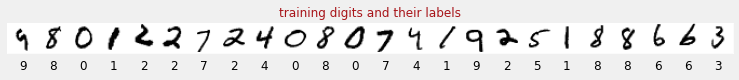

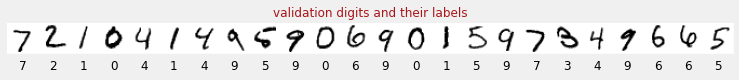

In [ ]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

### Apply Keras Model

In [ ]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


### Train and Validate the model

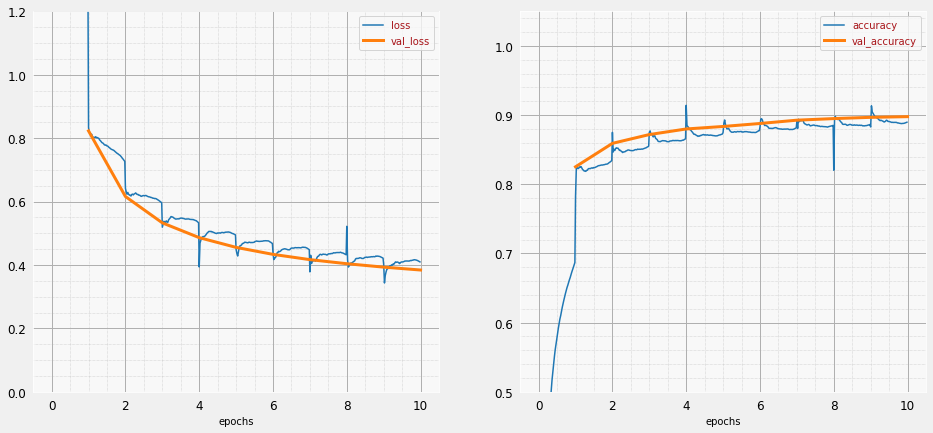

468/468 [==============================] - 4s 8ms/step - loss: 0.4086 - accuracy: 0.8900 - val_loss: 0.3841 - val_accuracy: 0.8977


In [ ]:

steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training])

### Visualized the Predicted Results

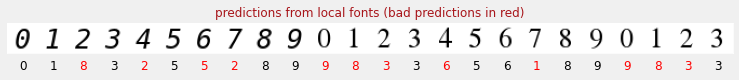

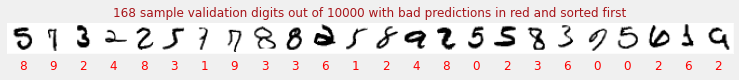

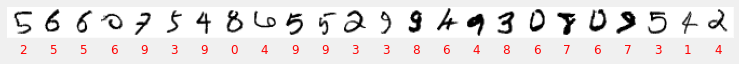

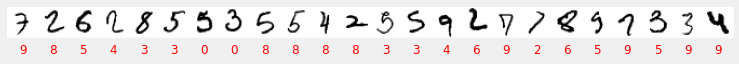

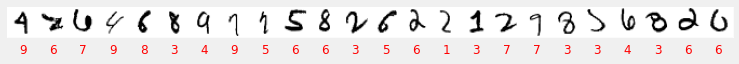

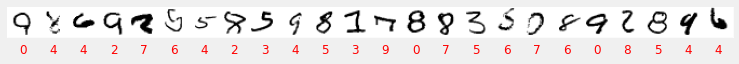

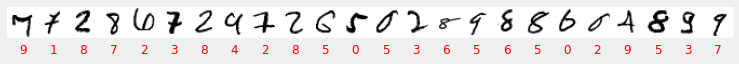

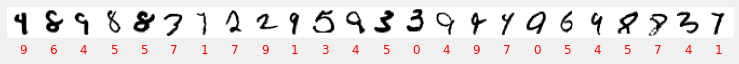

In [ ]:
def predict():
  # recognize digits from local fonts
  probabilities = model.predict(font_digits, steps=1)
  predicted_labels = np.argmax(probabilities, axis=1)
  display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

  # recognize validation digits
  probabilities = model.predict(validation_digits, steps=1)
  predicted_labels = np.argmax(probabilities, axis=1)
  display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

# check the predicted values
predict()

The model designed above is able to predict upto 90% of the digits, but this further can be improved.

### Adding more Layers

In [ ]:
model = tf.keras.Sequential(
  [
     tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='sigmoid'),
      tf.keras.layers.Dense(60, activation='sigmoid'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 200)               157000    
                                                                 
 dense_9 (Dense)             (None, 60)                12060     
                                                                 
 dense_10 (Dense)            (None, 10)                610       
                                                                 
Total params: 169,670
Trainable params: 169,670
Non-trainable params: 0
_________________________________________________________________


### Training and validating Data

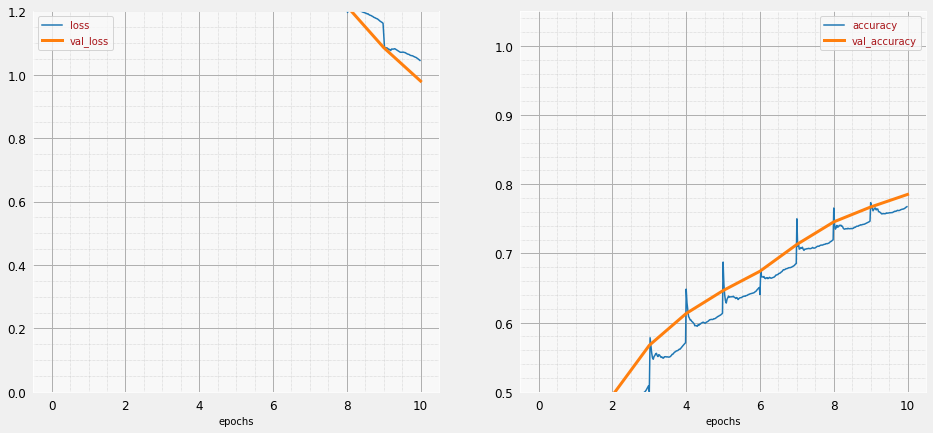

468/468 [==============================] - 4s 9ms/step - loss: 1.0439 - accuracy: 0.7680 - val_loss: 0.9799 - val_accuracy: 0.7853


In [ ]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training])

### Visualize the predicted values

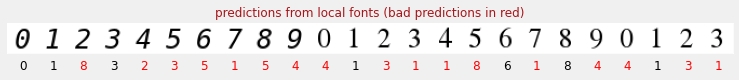

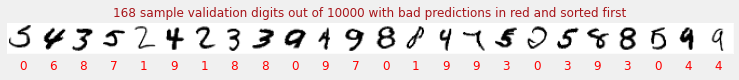

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


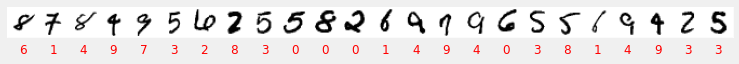

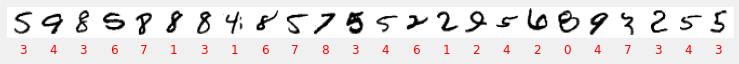

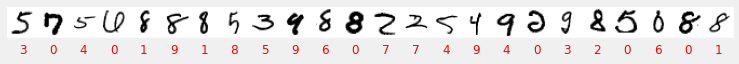

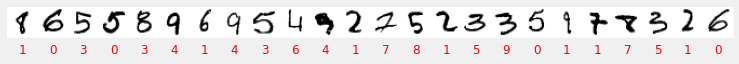

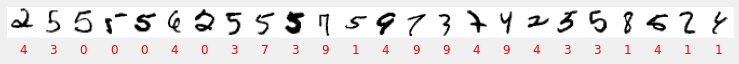

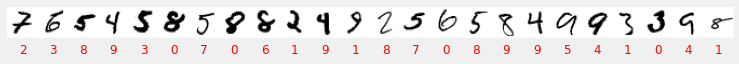

In [ ]:
# lets see the prediction
# calling the prediction function created above
predict()

With 10 times more parameters it should be 10 times better but somehow its not that accurate.

### Special Care for deep nueral network

## **Relu Activation**

For deep nueral networks sigmoid activation function is quite problematic. It compresses the values between 0 and 1. If this action is performed recursively the output and gradient of neuron disapperars completely.
In this case we will use '***Relu Activation***' function.

Here **Sigmoid** is replaced with **Relu** activation function and **sgd** optimiser is replaced with **adam**,

In [ ]:
model = tf.keras.Sequential(
  [
     tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dense(60, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 200)               157000    
                                                                 
 dense_12 (Dense)            (None, 60)                12060     
                                                                 
 dense_13 (Dense)            (None, 10)                610       
                                                                 
Total params: 169,670
Trainable params: 169,670
Non-trainable params: 0
_________________________________________________________________


### Train and Validate the model

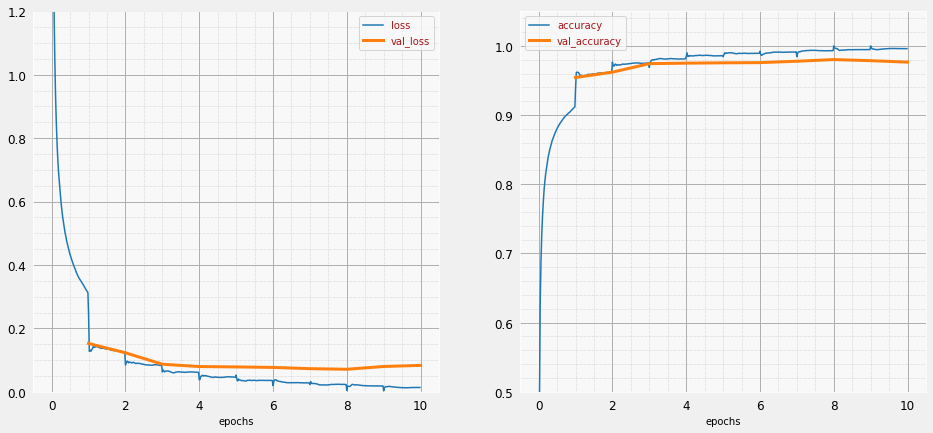

468/468 [==============================] - 4s 9ms/step - loss: 0.0136 - accuracy: 0.9960 - val_loss: 0.0833 - val_accuracy: 0.9765


In [ ]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training])

The accuracy has increased to 97% with the above changes.

### Visualize Prediction

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


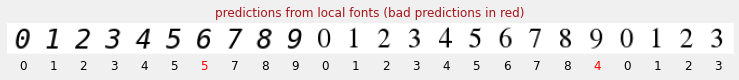

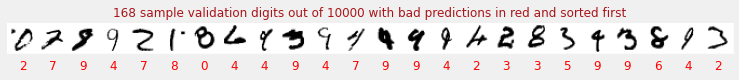

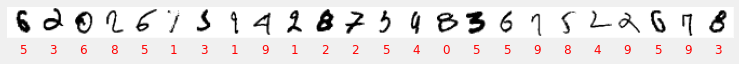

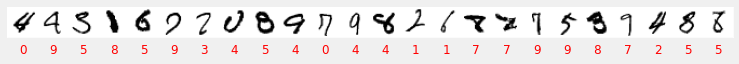

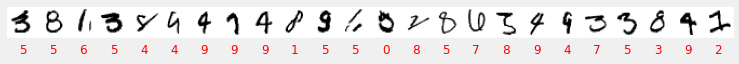

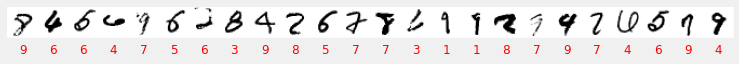

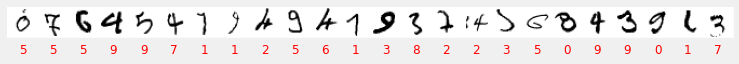

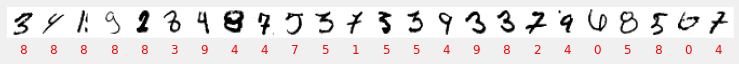

In [ ]:
# visualize the prediction

predict()

## Learning Rate Decay

Increasing the learning rate from 0.001 to 0.01.
I have also changed the zoom factor in PlotTraining to 5.

In [ ]:
optimizer=tf.keras.optimizers.Adam(lr=0.01)
model = tf.keras.Sequential(
  [
     tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dense(60, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=5)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 200)               157000    
                                                                 
 dense_15 (Dense)            (None, 60)                12060     
                                                                 
 dense_16 (Dense)            (None, 10)                610       
                                                                 
Total params: 169,670
Trainable params: 169,670
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Train and Validate Model

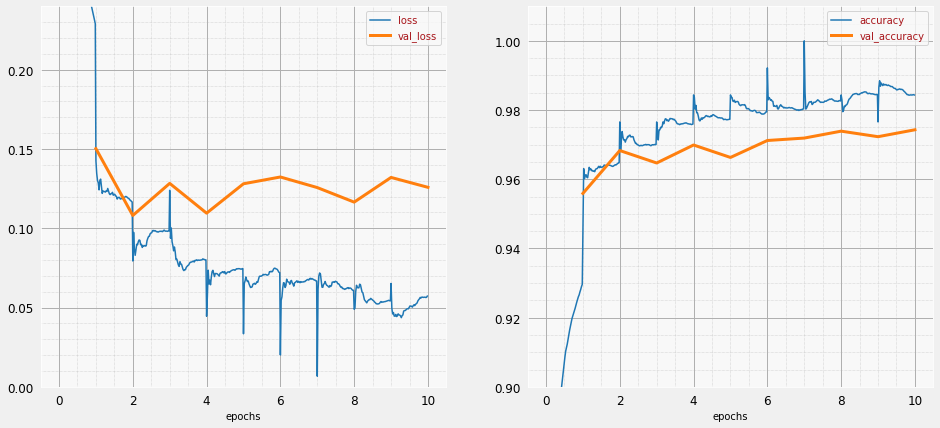

468/468 [==============================] - 4s 9ms/step - loss: 0.0572 - accuracy: 0.9843 - val_loss: 0.1258 - val_accuracy: 0.9743


In [ ]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training])

The above graph shows lot of noise in the training curve. The curves are going up and down that means we are going fast and its not helpful.

In this case we can apply keras learing rate scheduler which will decay the learning rate exponentially.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


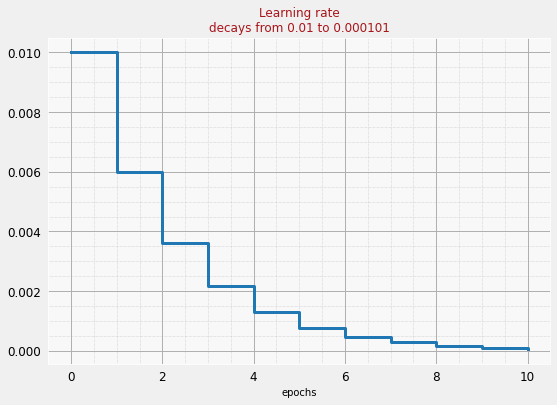

In [ ]:
# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, EPOCHS)

Adding lr_decay_callback to the list of callback functions in model.fit

### Train and Validate Model

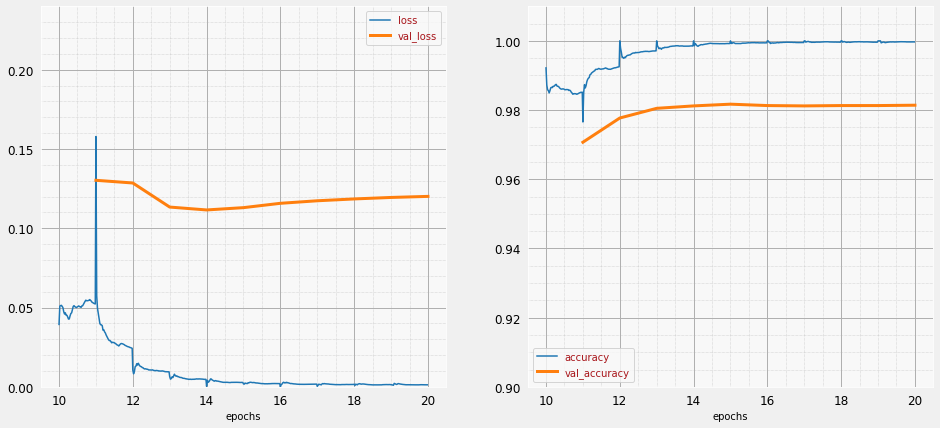

468/468 [==============================] - 4s 9ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.1201 - val_accuracy: 0.9814 - lr: 1.0078e-04


In [ ]:
# train and validate the model
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training,lr_decay_callback])


The noise is reduced and the accuracy is 98%.

#  Dropout Overfitting 

## Keral Model

The layers are now increased to 4 with the following number of neurons in each layer: 200, 100, 60, 10.
Also the zoom factor is increased to 10 in PlotTraining.
Adding 25% dropout rate with the following piece of code: 
tf.keras.layers.Dropout(0.25)

In [ ]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(100, activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(60, activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=10)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 200)               157000    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_18 (Dense)            (None, 100)               20100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_19 (Dense)            (None, 60)                6060      
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 dense_20 (Dense)            (None, 10)               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Learning Rate schedule

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


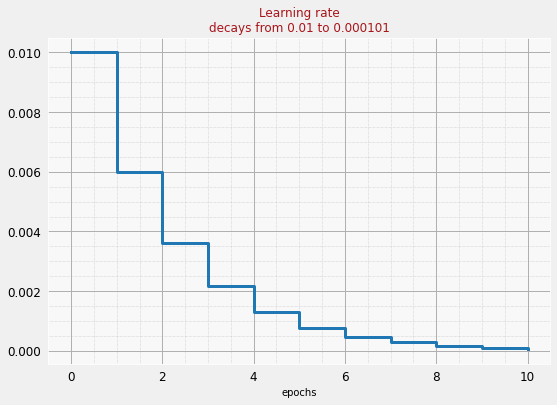

In [ ]:
# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, EPOCHS)

### Train and validate the model using the above callback scheduler function

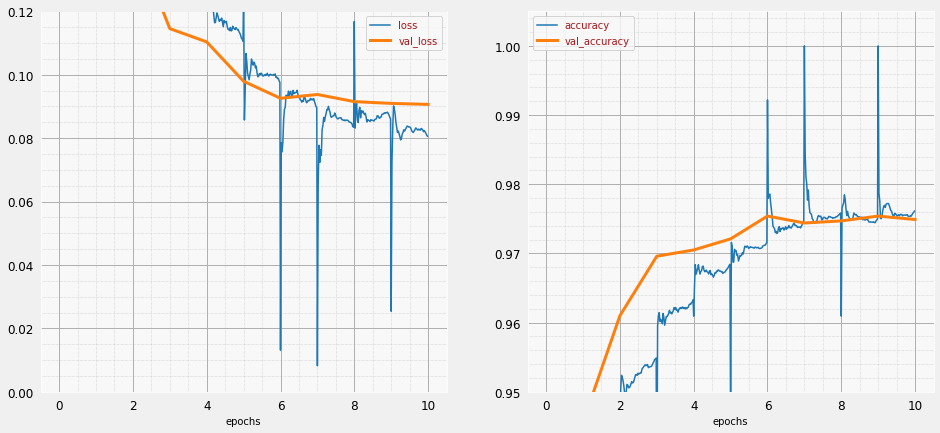

468/468 [==============================] - 5s 10ms/step - loss: 0.0804 - accuracy: 0.9762 - val_loss: 0.0906 - val_accuracy: 0.9749 - lr: 1.0078e-04


In [ ]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training, lr_decay_callback])

The noise still reappears and the accuracy is 97.5%.

### Lets Visualize the predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


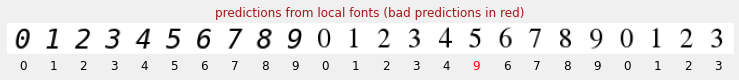

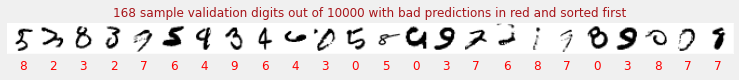

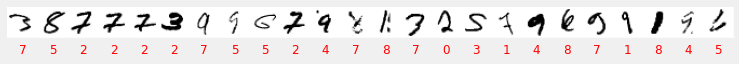

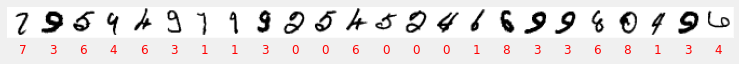

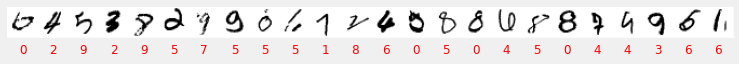

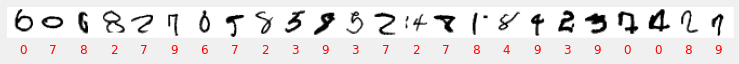

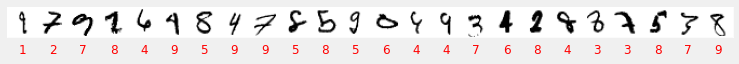

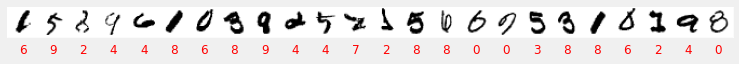

In [ ]:
# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

## Build a Convolutional network

Keras Model for convolutional network with no dropouts and zoom factor increased to 16 in the PlotTraining.

In [ ]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
      tf.keras.layers.Conv2D(kernel_size=3, filters=12, activation='relu', padding='same'),
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, activation='relu', padding='same', strides=2),
      tf.keras.layers.Conv2D(kernel_size=6, filters=32, activation='relu', padding='same', strides=2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=16)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 12)        120       
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 24)        10392     
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 32)          27680     
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_23 (Dense)            (None, 200)               313800    
                                                                 
 dense_24 (Dense)            (None, 10)               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Learning Rate Scheduler

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


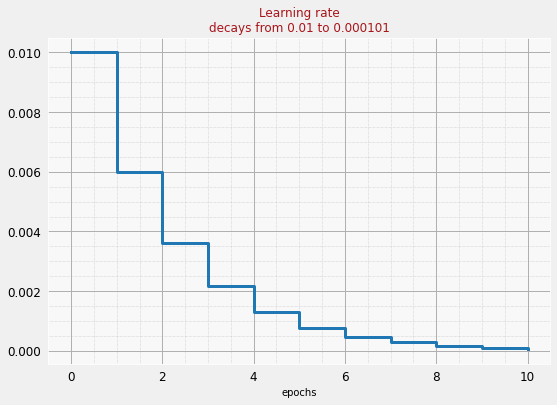

In [ ]:
# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, EPOCHS)

### Model training and validation

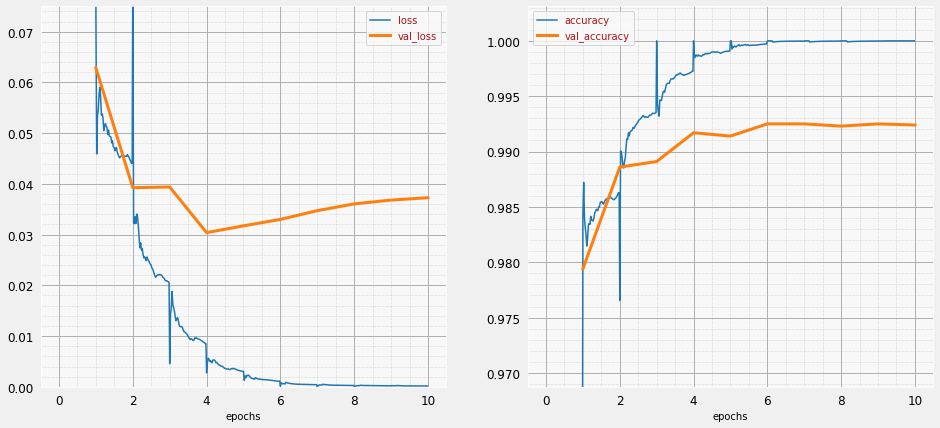

468/468 [==============================] - 8s 16ms/step - loss: 1.6671e-04 - accuracy: 1.0000 - val_loss: 0.0373 - val_accuracy: 0.9924 - lr: 1.0078e-04


In [ ]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training, lr_decay_callback])

### Visualize the predicted values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


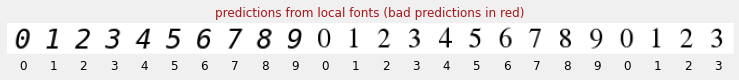

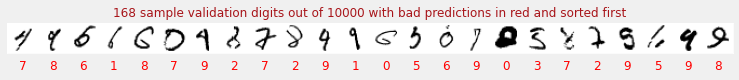

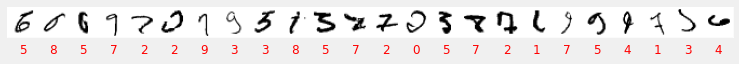

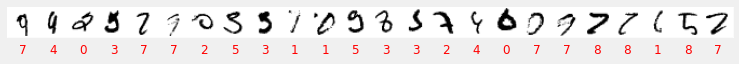

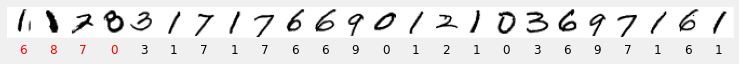

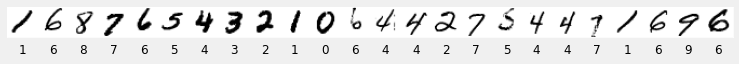

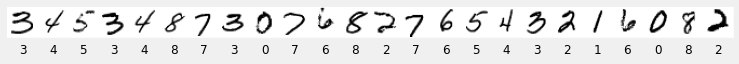

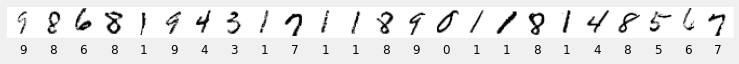

In [ ]:
# calling the common prediction function

predict()

The accuracy increased to 98.9%. From the above prediction its clear that most of the digits are correctly recongnized.

## **Drop out again**

Adding dropout layer between 2 dense layers in the network, with dropout rate 40%.

### Keras Model

In [ ]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(100, activation='relu'),
      tf.keras.layers.Dense(60, activation='relu'),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=10)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 200)               157000    
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_26 (Dense)            (None, 100)               20100     
                                                                 
 dense_27 (Dense)            (None, 60)                6060      
                                                                 
 dense_28 (Dense)            (None, 10)                610       
                                                                 
Total params: 183,770
Trainable params: 183,770
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Learning Rate Scheduler

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


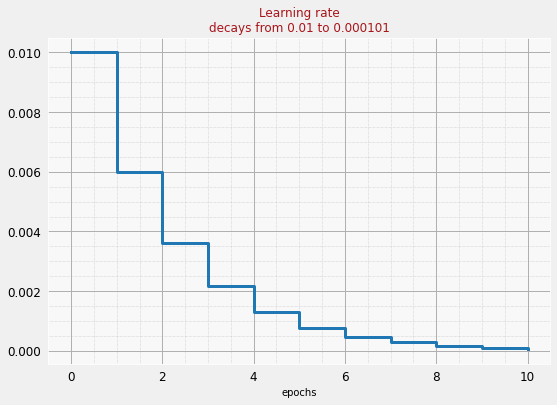

In [ ]:
# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, EPOCHS)

### Model training and validation

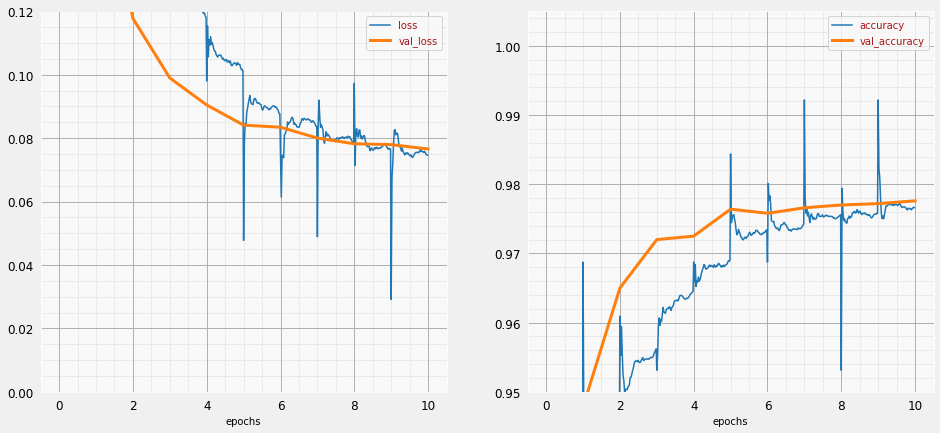

468/468 [==============================] - 5s 10ms/step - loss: 0.0749 - accuracy: 0.9766 - val_loss: 0.0766 - val_accuracy: 0.9776 - lr: 1.0078e-04


In [ ]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training, lr_decay_callback])

Dropout worked this time giving the accuracy of 99.2%.

## **Batch Normalization**

### tf.data.Dataset: parse files and prepare training and validation datasets

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image
  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(AUTO)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

# instantiate the datasets
training_dataset = get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)

# For TPU, we will need a function that returns the dataset
training_input_fn = lambda: get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_input_fn = lambda: get_validation_dataset(validation_images_file, validation_labels_file)

### Visualize Data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


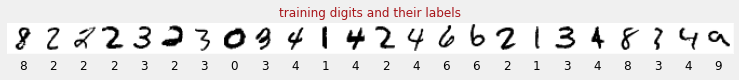

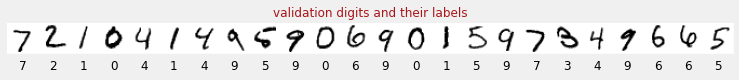

In [ ]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

### Keras Model

In [ ]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
      
      tf.keras.layers.Conv2D(kernel_size=3, filters=12, use_bias=False, padding='same'),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Conv2D(kernel_size=6, filters=32, use_bias=False, padding='same', strides=2),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Flatten(),
      
      tf.keras.layers.Dense(200, use_bias=False),
      tf.keras.layers.BatchNormalization(center=True, scale=False),
      tf.keras.layers.Activation('relu'),
      
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=16)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 12)        108       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 12)       36        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 12)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 24)        10368     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 24)       72        
 hNormalization)                                     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Learing rate Schedule

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


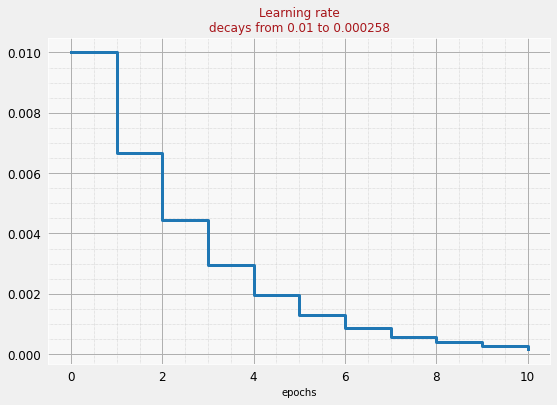

In [ ]:
# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.666, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, EPOCHS)

### Training and validating Model

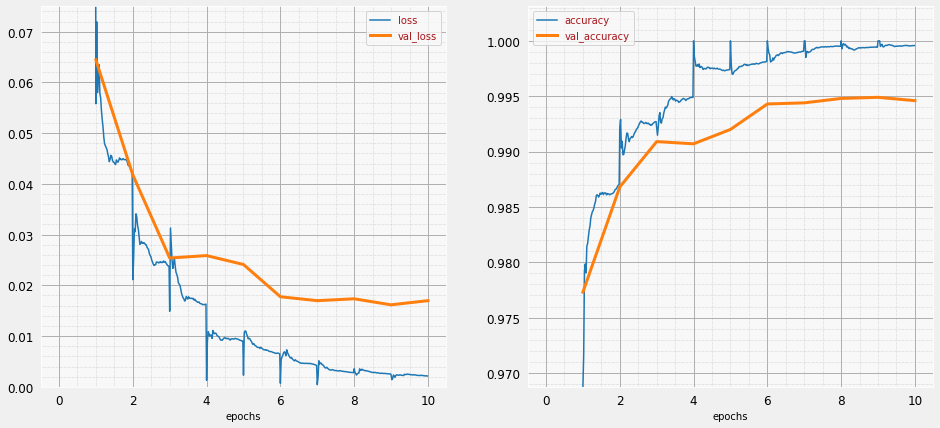

468/468 [==============================] - 8s 17ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.0170 - val_accuracy: 0.9946 - lr: 2.5779e-04


In [ ]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training, lr_decay_callback])

### Visualize Prediction

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


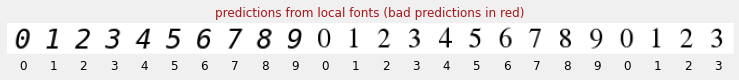

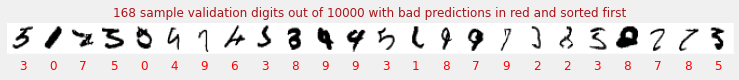

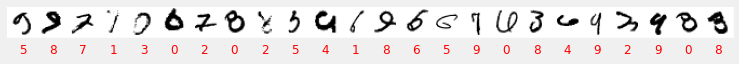

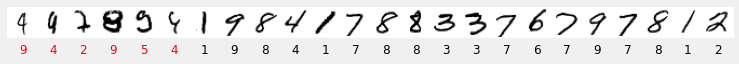

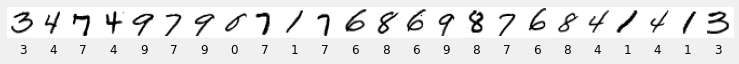

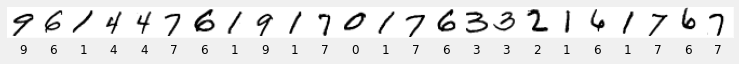

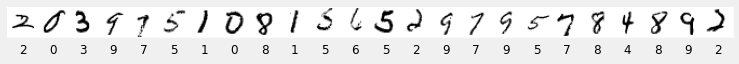

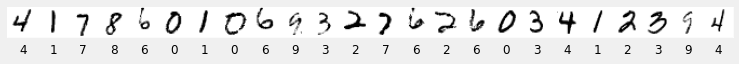

In [ ]:
# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

The accuracy of the model is 99.4%.